# 🔍 RAG Pipeline For LLMs 🚀


## 📖 Project Overview

This Notebook implements a **Retrieval-Augmented Generation (RAG)** pipeline using state-of-the-art language models and vector databases. The system intelligently retrieves relevant information from Wikipedia articles and generates accurate, context-aware answers to user questions.



### ✨ Key Features

- 📚 **Dynamic Knowledge Retrieval** from Wikipedia
- 🧮 **Semantic Search** using sentence transformers
- ⚡ **Fast Vector Similarity** with FAISS indexing
- 🤖 **Intelligent Answer Generation** using pre-trained QA models
- 📊 **Confidence Scoring** for answer quality assessment
- 🎛️ **Customizable Parameters** (chunk size, retrieval count, etc.)

### 🏗️ Architecture

```
User Query → Embedding → FAISS Search → Retrieve Chunks → QA Model → Answer + Confidence
```

### 🛠️ Tech Stack & Models

**🔧 Core Technologies:**
- **🤗 Transformers**: For tokenization and question-answering models
- **📝 Sentence Transformers**: For semantic embeddings
- **⚡ FAISS**: For efficient vector similarity search
- **📖 Wikipedia API**: For knowledge base content
- **🐍 Python**: Core implementation language

**🤖 AI Models Used:**
- **📏 Text Chunking**: `sentence-transformers/all-mpnet-base-v2` tokenizer
- **🧮 Vector Embeddings**: `sentence-transformers/all-mpnet-base-v2` (768-dimensional)
- **❓ Question Answering**: `deepset/roberta-base-squad2` (RoBERTa fine-tuned on SQuAD 2.0)
- **🔍 Vector Search**: FAISS IndexFlatL2 for L2 distance similarity

## 📦 Installation & Setup

### 🔧 Installing Required Dependencies

First, let's install all the necessary Python packages for our RAG pipeline:

In [1]:
!pip install wikipedia
!pip install transformers
!pip install sentence-transformers
!pip install faiss-cpu
!pip install tf_keras

### 📚 Importing Essential Libraries

Now let's import all the required libraries for our RAG implementation:

- **🔢 NumPy**: For numerical operations and array handling
- **📖 Wikipedia**: For fetching knowledge base content
- **🤗 Transformers**: For tokenization and QA models  
- **📝 Sentence Transformers**: For creating semantic embeddings
- **⚡ FAISS**: For efficient vector similarity search


In [2]:
import numpy as np
import wikipedia
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline
from sentence_transformers import SentenceTransformer
import faiss

## 📖 Retrieving Knowledge:

Fetch relevant Wikipedia articles based on a given topic:

In [3]:
def get_wikipedia_content(topic):
    try: 
        page = wikipedia.page(topic)
        return page.content
    except wikipedia.exceptions.PageError:
        return None
    except wikipedia.exceptions.DisambiguationError as e:
        # Handling cases where the topic is ambiguous:
        print(f"Ambiguous topic, Get more specific. Possible options: {e.options}")
        return None

# User Input:
topic = input("Enter a topic to learn about: ")
document = get_wikipedia_content(topic)

if not document:
    print("Could not find information on that topic.")
    exit()

## ✂️ Text Chunking:

Since Wikipedia articles can be long, we will split the text into smaller overlapping chunks for better retrieval:

- 📏 **Smart Segmentation**: Breaking text into manageable pieces (256 tokens each)
- 🔗 **Overlapping Chunks**: Maintaining context between segments (20 token overlap)
- ⚡ **Optimized Processing**: Avoiding token limit warnings and errors
- 🎯 **Better Retrieval**: Smaller chunks = more precise similarity matching

**Process:** Each chunk represents a focused piece of information that can be independently searched and retrieved for answering questions.

In [4]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")

def split_text(text, chunk_size = 256, chunk_overlap = 20):
    tokens = tokenizer.tokenize(text)
    chunks = []
    start = 0
    while start < len(tokens):
        end = min(start + chunk_size, len(tokens))
        chunks.append(tokenizer.convert_tokens_to_string(tokens[start:end]))
        if end == len(tokens):
            break
        start = end - chunk_overlap
    return chunks

chunks = split_text(document)
print(f"Total chunks: {len(chunks)}")

Token indices sequence length is longer than the specified maximum sequence length for this model (6573 > 512). Running this sequence through the model will result in indexing errors


Total chunks: 28


## 🧮 Vector Embeddings & Search Index:

### 🔄 Converting Text to Mathematical Vectors

Transforms human-readable text into numerical representations that machines can compare:

**🎯 The Process:**
- 📝 **Sentence Transformers**: Convert each text chunk into 768-dimensional vectors
- 🧠 **Semantic Encoding**: Capture meaning, not just keywords
- ⚡ **FAISS Indexing**: Store vectors for lightning-fast similarity search
- 📊 **L2 Distance**: Measure semantic similarity mathematically

To efficiently search for relevant chunks, we will use Sentence Transformers to convert text into embeddings and store them in a FAISS index:

In [5]:
embedding_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
embeddings = embedding_model.encode(chunks)

dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(np.array(embeddings))

## 🔍 Smart Query Processing & Retrieval

### ❓ From Question to Context

In the retrieval phase When a user asks a question, it will:


**The Retrieval Pipeline:**

1️⃣ **🎯 Query Embedding**: Convert user question to same vector space as knowledge chunks

2️⃣ **⚡ Similarity Search**: FAISS finds the k most semantically similar chunks  

3️⃣ **📋 Context Assembly**: Gather the most relevant information pieces

4️⃣ **🎛️ Customizable Retrieval**: Adjust k (number of chunks) based on needs


In [6]:
query = input("Ask a question about the topic: ")
query_embedding = embedding_model.encode([query])
query_embedding_array = np.array(query_embedding)

k = 3   # Number of chunks to retrieve
distances, indices = index.search(query_embedding_array, k)
retrieved_chunks = [chunks[i] for i in indices[0]]
print("Retrieved chunks: ")
for chunk in retrieved_chunks:
    print("- " + chunk)

Retrieved chunks: 
- ( portugal ), reims ( france ) and voros lobogo ( hungary ). the first european cup match took place on 4 september 1955, and ended in a 3 – 3 draw between sporting cp and partizan. the first goal in european cup history was scored by joao baptista martins of sporting cp. the inaugural final took place at the parc des princes between stade de reims and real madrid on 13 june 1956. the spanish squad came back from behind to win 4 – 3 thanks to goals from alfredo di stefano and marquitos, as well as two goals from hector rial. real madrid successfully defended the trophy next season in their home stadium, the santiago bernabeu, against fiorentina. after a scoreless first half, real madrid scored twice in six minutes to defeat the italians. in 1958, milan failed to capitalise after going ahead on the scoreline twice, only for real madrid to equalise. the final, held in heysel stadium, went to extra time where francisco gento scored the game - winning goal to allow rea

## 🤖 Intelligent Answer Generation

### 🧠 From Context to Precise Answers

The final step where retrieved knowledge becomes intelligent responses:

**🎯 Generation Process:**
- 🤖 **RoBERTa QA Model**: Pre-trained on SQuAD 2.0 dataset for optimal performance
- 📝 **Extractive Answering**: Finds exact answer spans within retrieved context
- 🎛️ **Context Fusion**: Combines multiple relevant chunks into unified context
- 📊 **Confidence Scoring**: Provides reliability metrics for each answer


**🔗 Complete RAG Flow**: `Wikipedia → Chunks → Embeddings → Retrieval → Generation → Answer + Confidence`

In [7]:
qa_model_name = "deepset/roberta-base-squad2"
qa_tokenizer = AutoTokenizer.from_pretrained(qa_model_name)
qa_model = AutoModelForQuestionAnswering.from_pretrained(qa_model_name)
qa_pipeline = pipeline("question-answering", model=qa_model, tokenizer=qa_tokenizer)

context = " ".join(retrieved_chunks)
answer = qa_pipeline(question = query, context = context)
print(f"Answer: {answer['answer']}")

Device set to use cpu


Answer: 15


### 📊 Answer Quality Assessment

Monitor the reliability and confidence of generated answers:


In [8]:
# Display confidence score
print(f"Confidence Score: {answer['score']:.4f} ({answer['score']*100:.1f}%)")


Confidence Score: 0.3278 (32.8%)


## 📊 Simple Visualizations

Let's create some basic visualizations to understand our RAG pipeline better:


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


C:\Users\sandh\AppData\Local\Temp\ipykernel_18820\3008433185.py:24: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\sandh\AppData\Local\Temp\ipykernel_18820\3008433185.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\sandh\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\sandh\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


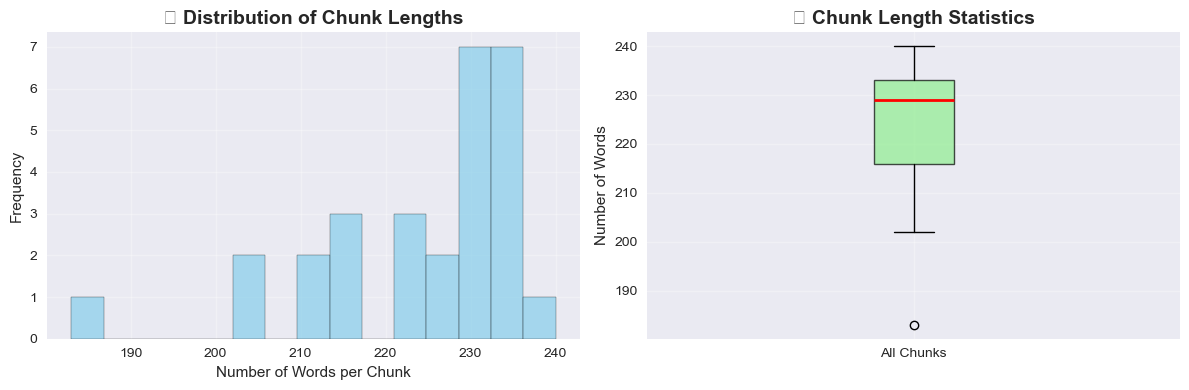

📈 Chunk Statistics:
Total chunks: 28
Average length: 224.1 words
Median length: 229.0 words
Min/Max length: 183/240 words


In [10]:
# 1. Chunk Length Distribution
chunk_lengths = [len(chunk.split()) for chunk in chunks]

plt.figure(figsize=(12, 4))

# Plot 1: Chunk length histogram
plt.subplot(1, 2, 1)
plt.hist(chunk_lengths, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('📏 Distribution of Chunk Lengths', fontsize=14, fontweight='bold')
plt.xlabel('Number of Words per Chunk')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Plot 2: Box plot of chunk lengths
plt.subplot(1, 2, 2)
plt.boxplot(chunk_lengths, patch_artist=True, 
            boxprops=dict(facecolor='lightgreen', alpha=0.7),
            medianprops=dict(color='red', linewidth=2))
plt.title('📊 Chunk Length Statistics', fontsize=14, fontweight='bold')
plt.ylabel('Number of Words')
plt.xticks([1], ['All Chunks'])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📈 Chunk Statistics:")
print(f"Total chunks: {len(chunks)}")
print(f"Average length: {np.mean(chunk_lengths):.1f} words")
print(f"Median length: {np.median(chunk_lengths):.1f} words")
print(f"Min/Max length: {min(chunk_lengths)}/{max(chunk_lengths)} words")


C:\Users\sandh\AppData\Local\Temp\ipykernel_18820\1499959522.py:20: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\sandh\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


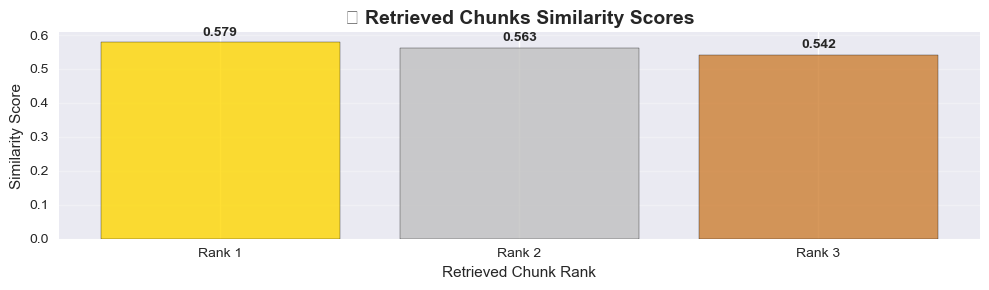

🔍 Retrieval Quality:
Best match similarity: 0.579
Average similarity: 0.561
Similarity drop-off: 0.038


In [11]:
# 2. Similarity Scores Visualization
similarity_scores = 1 / (1 + distances[0])  # Convert distances to similarity scores

plt.figure(figsize=(10, 3))

# Bar chart of retrieval similarities
bars = plt.bar(range(len(similarity_scores)), similarity_scores, 
               color=['gold', 'silver', '#CD7F32'], alpha=0.8, edgecolor='black')
plt.title('🎯 Retrieved Chunks Similarity Scores', fontsize=14, fontweight='bold')
plt.xlabel('Retrieved Chunk Rank')
plt.ylabel('Similarity Score')
plt.xticks(range(len(similarity_scores)), [f'Rank {i+1}' for i in range(len(similarity_scores))])

# Add value labels on bars
for i, (bar, score) in enumerate(zip(bars, similarity_scores)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"🔍 Retrieval Quality:")
print(f"Best match similarity: {similarity_scores[0]:.3f}")
print(f"Average similarity: {np.mean(similarity_scores):.3f}")
print(f"Similarity drop-off: {similarity_scores[0] - similarity_scores[-1]:.3f}")


C:\Users\sandh\AppData\Local\Temp\ipykernel_18820\1873837537.py:50: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\sandh\AppData\Local\Temp\ipykernel_18820\1873837537.py:50: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\sandh\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\sandh\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


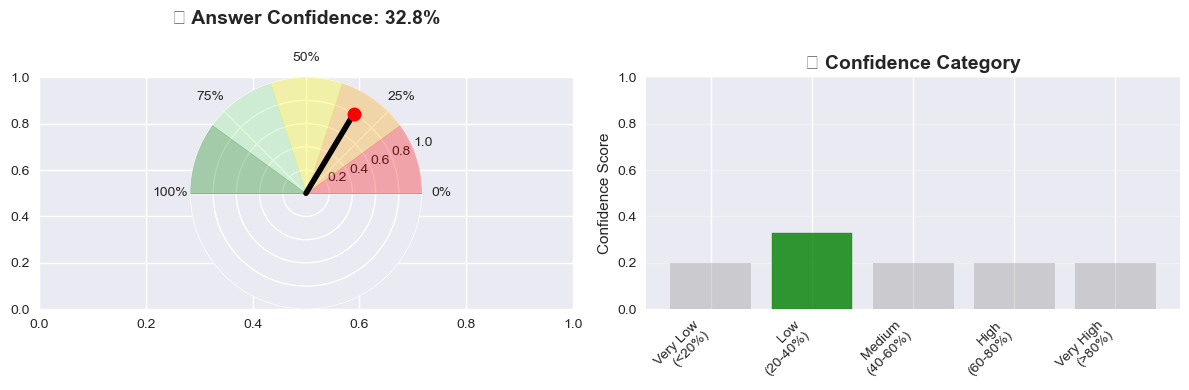

🤖 Answer Analysis:
Answer: '15'
Confidence: 32.8%
Quality: Low confidence


In [12]:
# 3. Answer Confidence Visualization
confidence = answer['score']

# Create a gauge-style confidence meter
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Confidence gauge
theta = np.linspace(0, np.pi, 100)
r = np.ones_like(theta)

# Color zones for confidence levels
colors = ['red', 'orange', 'yellow', 'lightgreen', 'green']
zones = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

ax1 = plt.subplot(121, projection='polar')
for i in range(len(zones)-1):
    start_angle = zones[i] * np.pi
    end_angle = zones[i+1] * np.pi
    theta_zone = np.linspace(start_angle, end_angle, 20)
    ax1.fill_between(theta_zone, 0, 1, color=colors[i], alpha=0.3)

# Add confidence needle
confidence_angle = confidence * np.pi
ax1.plot([confidence_angle, confidence_angle], [0, 0.8], 'black', linewidth=4)
ax1.plot(confidence_angle, 0.8, 'ro', markersize=10)

ax1.set_ylim(0, 1)
ax1.set_title(f'🎯 Answer Confidence: {confidence:.1%}', fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax1.set_xticklabels(['0%', '25%', '50%', '75%', '100%'])
ax1.grid(True)

# Simple bar chart showing confidence score
ax2 = plt.subplot(122)
confidence_levels = ['Very Low\n(<20%)', 'Low\n(20-40%)', 'Medium\n(40-60%)', 'High\n(60-80%)', 'Very High\n(>80%)']
current_level = min(int(confidence * 5), 4)

bars = ax2.bar(range(5), [0.2, 0.2, 0.2, 0.2, 0.2], alpha=0.3, color='gray')
bars[current_level].set_color('green')
bars[current_level].set_alpha(0.8)
bars[current_level].set_height(confidence if confidence <= 1 else 1)

ax2.set_ylim(0, 1)
ax2.set_ylabel('Confidence Score')
ax2.set_title('📊 Confidence Category', fontsize=14, fontweight='bold')
ax2.set_xticks(range(5))
ax2.set_xticklabels(confidence_levels, rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"🤖 Answer Analysis:")
print(f"Answer: '{answer['answer']}'")
print(f"Confidence: {confidence:.1%}")
print(f"Quality: {confidence_levels[current_level].split()[0]} confidence")


C:\Users\sandh\AppData\Local\Temp\ipykernel_18820\1089942319.py:26: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\sandh\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


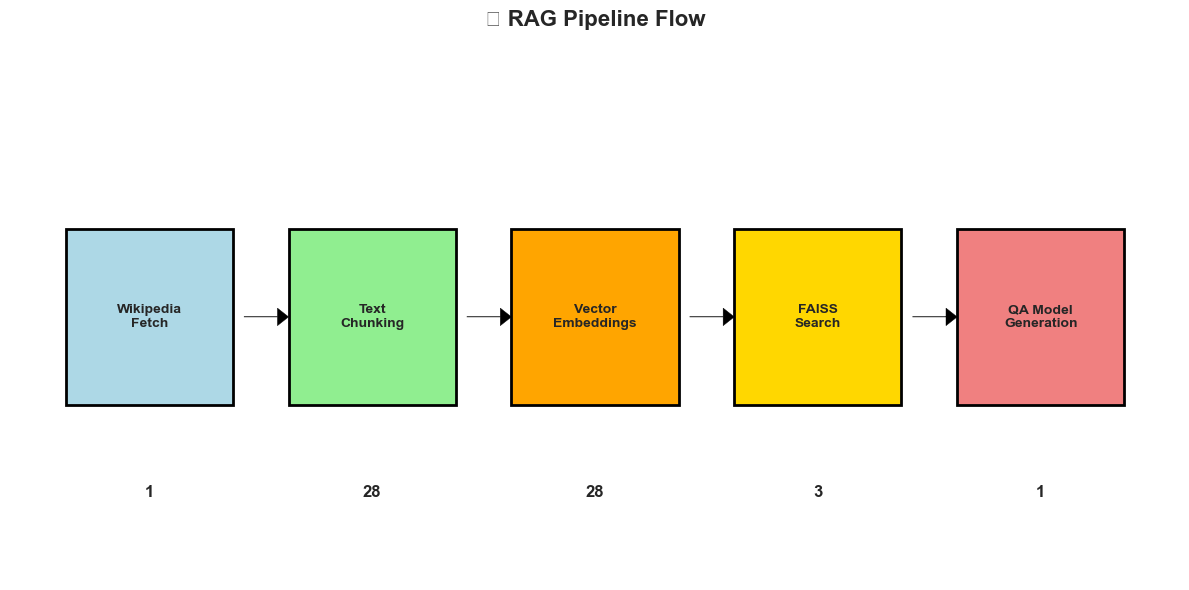

📊 Pipeline Summary:
Input: 1 Wikipedia article
Chunks created: 28
Embeddings generated: 28
Relevant chunks retrieved: 3
Final answer generated: 1


In [13]:
# 4. Simple Pipeline Flow Visualization
pipeline_steps = ['Wikipedia\nFetch', 'Text\nChunking', 'Vector\nEmbeddings', 'FAISS\nSearch', 'QA Model\nGeneration']
step_values = [1, len(chunks), len(embeddings), len(retrieved_chunks), 1]
step_colors = ['lightblue', 'lightgreen', 'orange', 'gold', 'lightcoral']

plt.figure(figsize=(12, 6))

# Flow diagram
for i, (step, value, color) in enumerate(zip(pipeline_steps, step_values, step_colors)):
    # Draw boxes
    rect = plt.Rectangle((i*2, 1), 1.5, 1, facecolor=color, edgecolor='black', linewidth=2)
    plt.gca().add_patch(rect)
    
    # Add labels
    plt.text(i*2 + 0.75, 1.5, step, ha='center', va='center', fontweight='bold', fontsize=10)
    plt.text(i*2 + 0.75, 0.5, f'{value}', ha='center', va='center', fontsize=12, fontweight='bold')
    
    # Add arrows
    if i < len(pipeline_steps) - 1:
        plt.arrow(i*2 + 1.6, 1.5, 0.3, 0, head_width=0.1, head_length=0.1, fc='black', ec='black')

plt.xlim(-0.5, len(pipeline_steps)*2)
plt.ylim(0, 3)
plt.title('🔄 RAG Pipeline Flow', fontsize=16, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"📊 Pipeline Summary:")
print(f"Input: 1 Wikipedia article")
print(f"Chunks created: {len(chunks)}")
print(f"Embeddings generated: {len(embeddings)}")
print(f"Relevant chunks retrieved: {len(retrieved_chunks)}")
print(f"Final answer generated: 1")
